So far, blocking has been calculated for both the models and the reanalyses. Unfortunately, R is not playing nice with me at the moment; some of the necessary packages are not compiling. For the moment, I'm doing a quick rewrite of some code just in order to view the stats.

In [2]:
#Necessary modules
import pandas as pd
import math
import cftime
pd.set_option('mode.chained_assignment', None)

In [3]:
basedir="/global/cscratch1/sd/marielp"
dats_mod=["CMCC-CESM","CMCC-CM","CNRM-CM5",
          "CanESM2","GFDL-CM3","GFDL-ESM2M",
          "HadCM3","HadGEM2-CC","IPSL-CM5A",
          "MIROC-ESM","MIROC5","MPI-ESM-MR",
          "MRI-CGCM3","MRI-ESM1","NorESM1-M"]
#dats_mod=["HadCM3"]
dirs_blob="BLOBS_NOREGIONAL"
dirs_stat="STATS_NOREGIONAL"
region_abbr=["NH","SH"]
#region_abbr=["NH"]
flist=[]
for d in dats_mod:
    for y in range(1980,2005):
        for r in region_abbr:
            str_file = "{:}/{:}/{:}/{:}_{:}_DJF_{:}_stats.txt".format(basedir,d,dirs_stat,d,y,r)
            #print(str_file)
            flist.append(str_file)

In [3]:
#Get the headers from the first file
#Read in the files
colnames=open(flist[0]).readlines()[0].strip().split(",")
print(colnames)
colnames_full=["var","bnum","region"]
colnames_full.extend(colnames)
colnames_full.append("fname")


['time', 'minlat', 'maxlat', 'minlon', 'maxlon', 'centlat', 'centlon', 'area']


In [4]:
#Iterate through everything
for d in dats_mod:
    for r in region_abbr:
        fname_stitch="STAT_CSV/CMIP5_{:}_DJF_{:}_stitchtable.csv".format(d,r)
        dat_total=pd.DataFrame(columns=colnames_full)
        for y in range(1980,2005):
            #print("d is {:} and r is {:}, y is {:}".format(d,r,y))
            str_file = "{:}/{:}/{:}/{:}_{:}_DJF_{:}_stats.txt".format(basedir,d,dirs_stat,d,y,r)
            #print("Opening file {:}".format(str_file))
            dat=open(str_file).readlines()
            nl=len(dat)
            if(nl>1):
                for l in range(1,nl):
                    lin=dat[l].strip().split("\t")
                    #print(lin)
                    if "Blob" in lin[0]:
                        bnum=lin[0].split()[1]
                        #print(bnum)
                    else:
                        #Create a dictionary to hold the values
                        dict_line={"var":d,"bnum":bnum,"time":lin[0],"region":r,"fname":str_file}
                        nc=1
                        for v in colnames[1:len(colnames)]:
                            dict_line[v]=float(lin[nc])
                            nc+=1
                        #print(dict_line)
                        dat_total=dat_total.append(dict_line,ignore_index=True)
                        
        #Print out the csv
        dat_total['area_km'] = dat_total['area']*(6371.*6371.)
        colnames_dat=dat_total.columns.tolist()
        colnames_dat[len(colnames_dat)-2]='area_km'
        colnames_dat[len(colnames_dat)-1]='fname'
        #reorder the columns (it was bugging me)
        dat_total=dat_total[colnames_dat]
        dat_total.to_csv(fname_stitch,index=False,na_rep='_')

In [5]:
#Do the same for the detect data
for d in dats_mod:
    for r in region_abbr:
        fname_detect="STAT_CSV/CMIP5_{:}_DJF_{:}_detecttable.csv".format(d,r)
        dat_total_detect=pd.DataFrame(columns=colnames_full)
        for y in range(1980,2005):
            #print("d is {:} and r is {:}, y is {:}".format(d,r,y))
            str_file = "{:}/{:}/{:}/{:}_{:}_DJF_{:}_stats_detect.txt".format(basedir,d,dirs_stat,d,y,r)
            #print("Opening file {:}".format(str_file))
            dat=open(str_file).readlines()
            nl=len(dat)
            if(nl>1):
                for l in range(1,nl):
                    lin=dat[l].strip().split("\t")
                    if "Blob" in lin[0]:
                        bnum=lin[0].split()[1]
                    else:
                        #Create a dictionary to hold the values
                        dict_line={"var":d,"bnum":bnum,"time":lin[0],"region":r,"fname":str_file}
                        nc=1
                        for v in colnames[1:len(colnames)]:
                            dict_line[v]=float(lin[nc])
                            nc+=1
                        dat_total_detect=dat_total_detect.append(dict_line,ignore_index=True)
                        
        #Print out the csv
        dat_total_detect['area_km'] = dat_total_detect['area']*(6371.*6371.)
        colnames_dat=dat_total_detect.columns.tolist()
        colnames_dat[len(colnames_dat)-2]='area_km'
        colnames_dat[len(colnames_dat)-1]='fname'
        #reorder the columns (it was bugging me)
        dat_total_detect=dat_total_detect[colnames_dat]
        dat_total_detect.to_csv(fname_detect,index=False,na_rep="_")
                        


In [6]:
#Look at when the data is merged-- are there any blobs that should be split?
def lon_convert_360_180(lon):
    distFrom180=lon-180
    retlon=-999
    if (distFrom180<0):
        retlon=lon
    else:
        retlon=distFrom180-180.
    return(retlon)


In [7]:
#Now we need to check all instances of merged vs split
for d in dats_mod:
    for r in region_abbr:
        #Read in the csv data for the stitchblobs and detectblobs files
        df_stitch=pd.read_csv("STAT_CSV/CMIP5_{:}_DJF_{:}_stitchtable.csv".format(d,r),na_filter = False)
        df_detect=pd.read_csv("STAT_CSV/CMIP5_{:}_DJF_{:}_detecttable.csv".format(d,r),na_filter = False)
        #We have the original stitch data and the data from detectblobs
        df_merged=pd.merge(df_stitch,df_detect,how='inner',on=['time','region','var','minlat','minlon','maxlat','maxlon','centlat','centlon'])
        df_allmerge=pd.merge(df_stitch,df_detect,how='outer',on=['time','region','var','minlat','minlon','maxlat','maxlon','centlat','centlon'])
        df_hasmerged=df_allmerge[df_allmerge['bnum_y'].isna()]
        df_issplit=df_allmerge[df_allmerge['bnum_x'].isna()]
        #print("Length of merged is {:}, allmerge is {:}, hasmerged={:}, issplit={:}".format(len(df_merged),len(df_allmerge),len(df_hasmerged),len(df_issplit)))
        df_merged['bnum2'] = df_merged['bnum_x']
        df_allmerge['bnum2'] = df_allmerge['bnum_x']
        df_hasmerged['bnum2'] = df_hasmerged['bnum_x']
        df_issplit['bnum2'] = df_issplit['bnum_y']        
        df_total=pd.DataFrame()
        for c in df_merged.columns.values:
            if not "_y" in c:
                if "_x" in c:
                    newname=c.replace("_x","")
                    df_total[newname]=df_merged[c]
                else:
                    df_total[c]=df_merged[c]
        df_total['merged']=['NO']*len(df_total)        
        for t in sorted(list(set(df_hasmerged['time']))):
            df_checkmerge=df_hasmerged[df_hasmerged['time'].str.match(t)]
            df_splits=df_issplit[df_issplit['time'].str.match(t)]
            if (len(df_splits)>0):
                for n in range(0,len(df_checkmerge)):
                    minlat_merged=df_checkmerge['minlat'].iloc[n]
                    maxlat_merged=df_checkmerge['maxlat'].iloc[n]
                    minlon_merged=df_checkmerge['minlon'].iloc[n]
                    maxlon_merged=df_checkmerge['maxlon'].iloc[n]
                    PER_BOUND=False
                    if (minlon_merged>maxlon_merged):
                        PER_BOUND=True
                        minlon_merged=lon_convert_360_180(minlon_merged)
                        maxlon_merged=lon_convert_360_180(maxlon_merged)
                        if (minlon_merged>maxlon_merged):
                            maxlon_merged+=360.
                    for m in range(0,len(df_splits)):
                        minlat_split=df_splits['minlat'].iloc[m]
                        maxlat_split=df_splits['maxlat'].iloc[m]
                        minlon_split=df_splits['minlon'].iloc[m]
                        maxlon_split=df_splits['maxlon'].iloc[m]


                        minlon_split_180=lon_convert_360_180(minlon_split)
                        maxlon_split_180=lon_convert_360_180(maxlon_split)

                        #Check original boundaries
                        is_inside=False
                        if ((minlat_split>=minlat_merged) &
                           (maxlat_split<=maxlat_merged)&
                           (minlon_split>=minlon_merged)&
                           (maxlon_split<=maxlon_merged)):
                            is_inside=True
                        else:
                            if ((minlat_split>=minlat_merged) &
                           (maxlat_split<=maxlat_merged)&
                           (minlon_split_180>=minlon_merged)&
                           (maxlon_split_180<=maxlon_merged)):
                                is_inside=True
                        if (is_inside==True):
                            merge_dict={}
                            for c in df_splits.columns.values:
                                if not "_x" in c:
                                    if "_y" in c:
                                        if ((c!="bnum_y") & (c!="fname_y")):
                                            newname=c.replace("_y","")
                                            merge_dict[newname]=df_splits[c].iloc[m]
                                    else:
                                        merge_dict[c] = df_splits[c].iloc[m]
                            merge_dict['bnum']=df_checkmerge['bnum_x'].iloc[n]
                            merge_dict['merged']='YES'
                            merge_dict['fname']=df_checkmerge['fname_x'].iloc[n]
                            df_total=df_total.append(merge_dict,ignore_index=True)
        df_total=df_total.sort_values(['var','region','time'])
        #print("Length of stitchblobs for {:} {:} was {:} and length of detectblobs was {:}; length of merged dataframe is {:}".format(d,r,len(df_stitch),len(df_detect),len(df_total)))
        fname_out="STAT_CSV/CMIP5_{:}_DJF_{:}_merged_table.csv".format(d,r)
        df_total.to_csv(fname_out,index=False,na_rep="_")

            


In [8]:
#Summarize the data
def deg2rad(deg):
    return(deg*(math.pi/180.))

def getDistanceFromLatLonInKm(lat1,lon1,lat2,lon2):
    R=6371.
    dlat=deg2rad(lat2-lat1)
    dlon=deg2rad(lon2-lon1)
    a=math.sin(dlat/2.)*math.sin(dlat/2.) + math.cos(deg2rad(lat1)) *\
    math.cos(deg2rad(lat2)) *math.sin(dlon/2.)*math.sin(dlon/2.)
    
    b = 2. * math.atan2(math.sqrt(a),math.sqrt(1-a))
    d=R*b
    return(d)
#for f in sorted(list(set(df_total['fname']))):

for d in dats_mod:
    calendar="noleap"
    if d=="HadCM3" or d=="HadGEM2-CC":
        calendar="360_day"
    for r in region_abbr:
        dat_in=pd.read_csv("STAT_CSV/CMIP5_{:}_DJF_{:}_merged_table.csv".format(d,r),na_filter = False)
        dat_summ=pd.DataFrame()
        for f in sorted(list(set(dat_in['fname']))):
            dat_sub = dat_in[dat_in['fname'].str.match(f)]
            bnum_unique=set(dat_sub['bnum'])
            for b in sorted(list(bnum_unique)):
                dat_bsub=dat_sub.loc[dat_sub['bnum']==b]
                dat_bsub = dat_bsub.sort_values('time')
                #print(dat_bsub)
                sline=dat_bsub.iloc[0]
                eline=dat_bsub.iloc[len(dat_bsub)-1]
                stime=sline['time']
                etime=eline['time']
                ysnum=int(stime[:4])
                msnum=int(stime[5:7])
                dsnum=int(stime[8:10])
                ssnum=int(stime[11:])/3600
                yenum=int(etime[:4])
                menum=int(etime[5:7])
                denum=int(etime[8:10])
                senum=int(etime[11:])/3600
                if calendar=="360_day":
                    sdate=cftime.Datetime360Day(ysnum,msnum,dsnum,ssnum)
                    edate=cftime.Datetime360Day(yenum,menum,denum,senum)
                else:
                    sdate=cftime.DatetimeNoLeap(ysnum,msnum,dsnum,ssnum)
                    edate=cftime.DatetimeNoLeap(yenum,menum,denum,senum)
                td=edate-sdate
                num_days = td.days +1
                num_hrs = td.seconds/(3600*24)
                num_tot_days = num_days + num_hrs 
                avg_clat=(sline['centlat']+eline['centlat'])/2.
                dict_bsub={"var":sline['var'],"bnum":b,"region":sline['region'],"startdate":sline['time'],"enddate":eline['time'],
                           "duration_days":num_tot_days,"mean_centlat":dat_bsub['centlat'].mean(),
                          "start_centlat":sline['centlat'],"start_centlon":sline['centlon'],
                          "end_centlat":eline['centlat'],"end_centlon":eline['centlon'],
                           "mean_centlat":dat_bsub['centlat'].mean(),
                          "dist_km":getDistanceFromLatLonInKm(sline['centlat'],sline['centlon'],
                                                             eline['centlat'],eline['centlon']),
                          "zonal_dist_km":getDistanceFromLatLonInKm(avg_clat,sline['centlon'],
                                                                  avg_clat,eline['centlon']),
                          "min_area_km":dat_bsub['area_km'].min(),"max_area_km":dat_bsub['area_km'].max(),
                          "mean_area_km":dat_bsub['area_km'].mean()}
                dict_bsub['zonal_speed_km']=dict_bsub['dist_km']/(dict_bsub['duration_days']*24.)
                dict_bsub['fname']=sline['fname']
                if (len(dat_bsub[dat_bsub['merged'].str.contains('YES')])>0):
                    dict_bsub['merged'] = 'YES'
                else:
                    dict_bsub['merged'] = 'NO'
                dat_summ=dat_summ.append(dict_bsub,ignore_index=True)
        #Write to file
        colnames_summ=dict_bsub.keys()
        dat_summ=dat_summ[colnames_summ]
        fname_summ="STAT_CSV/CMIP5_{:}_DJF_{:}_summ_table.csv".format(d,r)
        dat_summ.to_csv(fname_summ,index=False,na_rep="_")


[Text(0, 0, 'CMCC-CESM'),
 Text(0, 0, 'CMCC-CM'),
 Text(0, 0, 'CNRM-CM5'),
 Text(0, 0, 'CanESM2'),
 Text(0, 0, 'GFDL-CM3'),
 Text(0, 0, 'GFDL-ESM2M'),
 Text(0, 0, 'HadCM3'),
 Text(0, 0, 'HadGEM2-CC'),
 Text(0, 0, 'IPSL-CM5A'),
 Text(0, 0, 'MIROC-ESM'),
 Text(0, 0, 'MIROC5'),
 Text(0, 0, 'MPI-ESM-MR'),
 Text(0, 0, 'MRI-CGCM3'),
 Text(0, 0, 'MRI-ESM1'),
 Text(0, 0, 'NorESM1-M')]

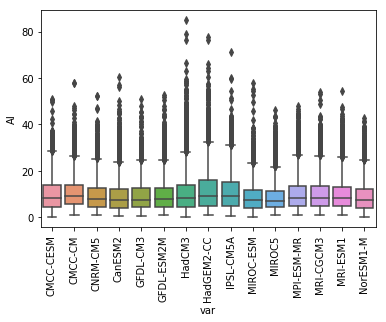

In [25]:
#Make a summary table of values per dataset
import seaborn as sns
summ_frame=pd.DataFrame()
summ_area = pd.DataFrame()
for d in dats_mod:
    fname_summ="{:}/{:}/STATS_SUMM/{:}_DJF_NH_summtable.csv".format(basedir,d,d)
    fname_tot="{:}/{:}/STATS_SUMM/{:}_DJF_NH_indicestable.csv".format(basedir,d,d)

    summ_sub=pd.read_csv(fname_summ)
    tot_sub=pd.read_csv(fname_tot)
    summ_area = summ_area.append(tot_sub)
    d_dict={}
    d_dict['var']=d
    d_dict['region']="NH"
    d_dict['Unique_blobs']=len(summ_sub)
    d_dict['Merged_blobs']=len(summ_sub[summ_sub['merged']=='YES'])
    d_dict['Avg_duration']=summ_sub['duration_days'].mean()
    d_dict['Num_days']=len(list(set(tot_sub['time'])))
    d_dict['Avg_num_days']=d_dict['Num_days']/len(list(set(tot_sub['year'])))
    d_dict['Avg_lat']=summ_sub['mean_centlat'].mean()
    d_dict['Avg_size_km']=tot_sub['area_km'].mean()
    d_dict['Avg_AI']=summ_sub['mean_AI'].mean()
    summ_frame=summ_frame.append(d_dict,ignore_index=True)
colnames_tab=d_dict.keys()
summ_frame=summ_frame[colnames_tab]
    
#g=sns.boxplot(data=summ_area,x='var',y='area_km') 
#g.set_xticklabels(g.get_xticklabels(),rotation=90)
g2=sns.boxplot(data=summ_area,x='var',y='AI') 
g2.set_xticklabels(g.get_xticklabels(),rotation=90)

,AI,BI,amax,area,area_km,bnum,bnum2,calendar,centlat,centlon,...,minlat,minlon,month,region,season,sec,sum_area,time,var,year
0,8.463087,2.168858,214.476251,0.13714,5.566463e+06,1.0,1.0,noleap,40.82199,73.125,...,31.54452,45.00,12,NH,DJF,43200,6.696848e+06,1980-12-02-43200,CMCC-CESM,1980
1,10.272684,1.569852,265.644716,0.15280,6.202097e+06,1.0,1.0,noleap,40.82199,71.250,...,31.54452,48.75,12,NH,DJF,43200,6.655635e+06,1980-12-03-43200,CMCC-CESM,1980
2,13.238274,2.178285,275.853412,0.17636,7.158389e+06,1.0,1.0,noleap,42.67740,76.875,...,31.54452,52.50,12,NH,DJF,43200,8.044940e+06,1980-12-04-43200,CMCC-CESM,1980
3,12.767958,2.887167,250.751251,0.18961,7.696202e+06,1.0,1.0,noleap,40.82186,76.875,...,27.83344,52.50,12,NH,DJF,43200,8.687070e+06,1980-12-05-43200,CMCC-CESM,1980
4,7.710168,2.343527,199.355085,0.14017,5.689450e+06,1.0,1.0,noleap,37.11100,78.750,...,27.83344,52.50,12,NH,DJF,43200,6.347772e+06,1980-12-06-43200,CMCC-CESM,1980


In [20]:
summ_frame

,var,region,Unique_blobs,Merged_blobs,Avg_duration,Num_days,Avg_num_days,Avg_lat,Avg_size_km,Avg_AI
0,CMCC-CESM,NH,357.0,34.0,9.369748,1964.0,75.538462,46.321445,5.063712e+06,8.793330
1,CMCC-CM,NH,417.0,40.0,8.450839,1995.0,76.730769,46.657578,4.622822e+06,9.887928
2,CNRM-CM5,NH,387.0,35.0,8.966408,1992.0,76.615385,46.083002,4.658881e+06,8.223105
3,CanESM2,NH,344.0,27.0,8.648256,1790.0,68.846154,47.364768,4.888956e+06,8.135220
4,GFDL-CM3,NH,414.0,42.0,8.748792,1991.0,76.576923,44.878435,4.755534e+06,8.181360
5,GFDL-ESM2M,NH,391.0,35.0,8.992327,1950.0,75.000000,45.730926,4.748460e+06,8.448101
6,HadCM3,NH,560.0,185.0,10.433929,2227.0,85.653846,45.470873,6.657136e+06,8.831482
7,HadGEM2-CC,NH,501.0,192.0,10.618762,2234.0,85.923077,46.497696,7.181024e+06,10.198531
8,IPSL-CM5A,NH,336.0,33.0,8.651786,1860.0,71.538462,46.027681,5.203694e+06,9.776963
9,MIROC-ESM,NH,397.0,33.0,8.516373,1894.0,72.846154,45.627982,4.665808e+06,7.977979


In [18]:
#Look at when the data is merged-- are there any blobs that should be split?
def lon_convert_360_180(lon):
    distFrom180=lon-180
    retlon=-999
    if (distFrom180<0):
        retlon=lon
    else:
        retlon=distFrom180-180.
    return(retlon)


#We have the file names and the 
import matplotlib.pyplot as plt
import matplotlib
summ_gt_had = summ_gt[(summ_gt['var'].str.match("HadCM3")| summ_gt['var'].str.match("HadGEM2-CC"))]


fvec=sorted(list(set(summ_gt_had['fname'])))
f=fvec[18]

fig = plt.figure(figsize=(30,30))
dsub=summ_gt_had[summ_gt_had['fname']==f]
sdate=dsub['startdate'].item()
bnum=dsub['bnum'].item()
var=dsub['var'].item()
ydate=sdate[:4]
mdate=sdate[5:7]
if (int(mdate)<12):
    ydate+=1

#Open the corresponding merged file and find the correct bnum
fopen="STAT_CSV/CMIP5_{:}_DJF_NH_merged_table.csv".format(var)
f_orig="STAT_CSV/CMIP5_{:}_DJF_NH_stitchtable.csv".format(var)
dat_in=pd.read_csv(fopen,na_filter = False)
dat_orig=pd.read_csv(f_orig)
dat_match=dat_in[dat_in.fname==f]
whole_orig=dat_orig[dat_orig.fname==f]
dat_bsub=dat_match[dat_match.bnum==bnum]
orig_bsub=whole_orig[whole_orig.bnum==bnum]
n=len(orig_bsub)

i=1
pts_x=[]
pts_y=[]

for d in sorted(list(set(orig_bsub['time']))):
    ax=fig.add_subplot(9,10,i)
    ax.set_xlim(-180,(360+180))
    ax.set_ylim(25,75)
    orig_pts=orig_bsub[orig_bsub['time']==d]
    #print(orig_pts)
    dat_pts = dat_bsub[dat_bsub['time']==d]
    dat_pts['lon_180'] = dat_pts['centlon'].apply(lon_convert_360_180)
    dat_pts['min_180']=dat_pts['minlon'].apply(lon_convert_360_180)
    dat_pts['max_180']=dat_pts['maxlon'].apply(lon_convert_360_180)
    #print("there are {:} points at i={:} ({:})".format(len(dat_pts),i,d))
    co=orig_pts['centlon'].item()

    xo=orig_pts['minlon'].item()
    xo_180=lon_convert_360_180(xo)
    xmo=orig_pts['maxlon'].item()
    if (xmo<xo):
        #Does shifting it to 180 help?
        xo=xo_180
    xow=xmo-xo
    if (xow<0):
        xmo=xmo+360.
        xow=xmo-xo
    if (co>xmo):
        co-=360.

    yo=orig_pts['minlat'].item()
    yoh=orig_pts['maxlat']-orig_pts['minlat']
    ro=matplotlib.patches.Rectangle((xo,yo),xow,yoh,facecolor="none",edgecolor="g",linewidth=2)
    ax.add_patch(ro)
    pts_x.append(co)
    pts_y.append(orig_pts['centlat'].item())
    ax.plot(pts_x,pts_y)
    ax.scatter(co,orig_pts['centlat'],c='green')
    ax.set_title("{:}".format(d))
    for it,r in dat_pts.iterrows():
        x_split=r['centlon']
        x_min=r['minlon']
        x_max=r['maxlon']
        y_min=r['minlat']
        y_max=r['maxlat']
        if (x_split<xo):
            x_split+=360.
        elif (x_split>xmo):
            x_split-=360
        y_split=r['centlat']
        if ((x_split>x_max) & (x_split>180)):
            x_min+=360
            x_max+=360
        if (x_min>x_max):
            x_min-=360
        if (x_split<x_min):
            x_min-=360
            x_max-=360
        #print("bounds: {:},{:} and centlon is {:}".format(x_min,x_max,x_split))
        rs=matplotlib.patches.Rectangle((x_min,y_min),(x_max-x_min),(y_max-y_min),facecolor='none',edgecolor='r')
        ax.add_patch(rs)
        ax.scatter(x_split,y_split,c='red')
    i+=1
        
    


        
        
    
    

IndexError: list index out of range